Benchmarking on MISAR-seq(E11_0_S1, E13_5_S1, E15_5_S1, E18_5_S1)

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ranksums
import anndata as ad

from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score

def purity_score(y_true, y_pred):
    cm = contingency_matrix(y_true, y_pred)
    return np.sum(np.max(cm, axis=0)) / np.sum(cm)

def cluster_entropy(y_true, y_pred, base=np.e):
    cm = contingency_matrix(y_true, y_pred)
    cluster_sizes = np.sum(cm, axis=0)            
    entropies = []
    for j in range(cm.shape[1]):
        p_ij = cm[:, j] / cluster_sizes[j]   
      
        nz = p_ij > 0
        h_j = -np.sum(p_ij[nz] * np.log(p_ij[nz]) / np.log(base))
        entropies.append(h_j)
    return np.sum((cluster_sizes / np.sum(cluster_sizes)) * np.array(entropies))

def caculate_weighted_F1_score(adata,method): 
    from sklearn.metrics import f1_score
    df=adata.obs.copy()
    f1_scores = {}
    weights = {}
    for label in df['Ground Truth'].unique():
                df['Ground Truth_bin'] = (df['Ground Truth'] == label).astype(int)
                
               
                cluster_ratio = df.groupby(f'{method}')['Ground Truth_bin'].mean()
            
                cluster_label = (cluster_ratio > 0.5).astype(int)
            
                df['cluster_pred'] = df[f'{method}'].map(cluster_label)

                f1 = f1_score(df['Ground Truth_bin'], df['cluster_pred'])

                f1_scores[label] = f1

                weights[label] = (df['Ground Truth'] == label).mean()

    weighted_f1= sum(f1_scores[label] * weights[label] for label in f1_scores)

    return weighted_f1



d:\anaconda\envs\pytorch\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
d:\anaconda\envs\pytorch\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
d:\anaconda\envs\pytorch\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
d:\anaconda\envs\pytorch\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
d:\anaconda\envs\pytorch\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  

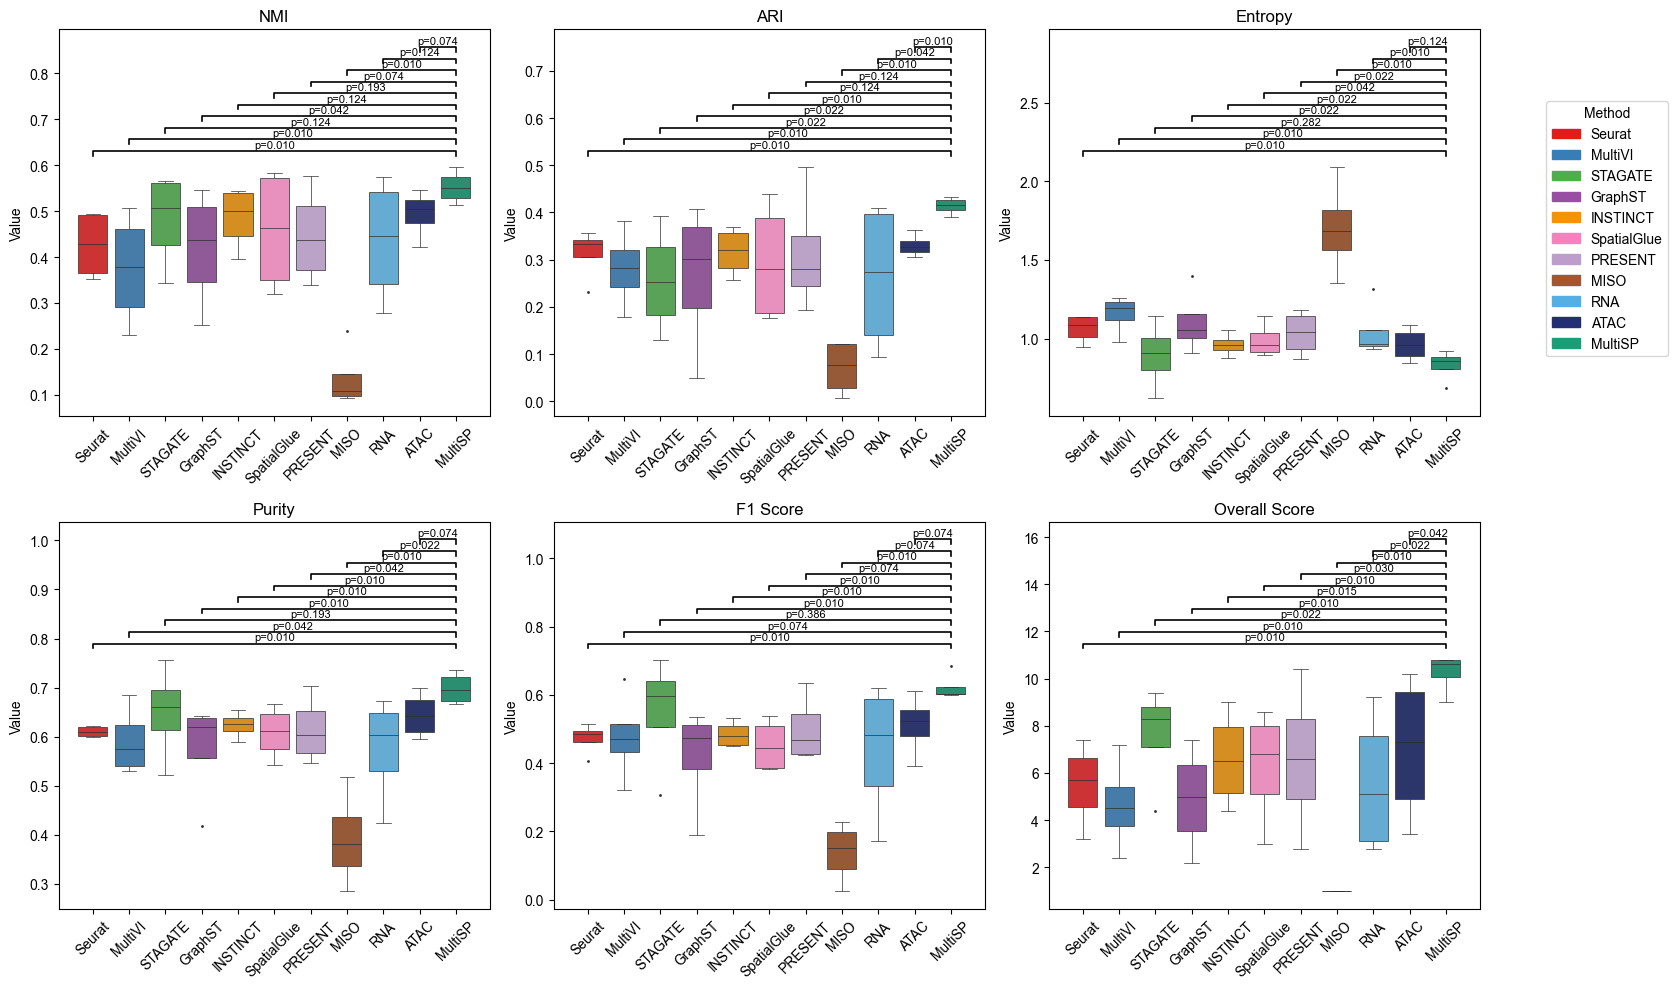

In [8]:
def calculate_as_for_each_sample(df):
    df['RANK_NMI'] = df.groupby('samples')['NMI'].rank(ascending=True)
    df['RANK_ARI'] = df.groupby('samples')['ARI'].rank(ascending=True)
    df['RANK_Entropy'] = df.groupby('samples')['Entropy'].rank(ascending=False)  # Entropy: smaller is better, so descending
    df['RANK_Purity'] = df.groupby('samples')['Purity'].rank(ascending=True)
    df['RANK_F1 Score'] = df.groupby('samples')['F1 Score'].rank(ascending=True)
    
    df['Overall Score'] = df[['RANK_NMI', 'RANK_ARI', 'RANK_Entropy', 'RANK_Purity','RANK_F1 Score']].mean(axis=1)
    
    return df

plt.rcParams['font.family'] = 'Arial'
colorslist=['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#F29403', '#F781BF', '#BC9DCC', '#A65628', '#54B0E4',
                   '#222F75', '#1B9E77', '#B2DF8A', '#E3BE00', '#FB9A99', '#E7298A', '#910241', '#00CDD1', '#A6CEE3',
                   '#CE1261', '#5E4FA2', '#8CA77B', '#00441B', '#DEDC00', '#DCF0B9', '#8DD3C7', '#999999']

all_methods_list = []
method_list = ['Seurat', 'MultiVI', 'STAGATE', 'GraphST', 'INSTINCT', 'SpatialGlue', 'PRESENT', 'MISO', 'RNA', 'ATAC', 'MultiSP']
slice_names = ['E11_0', 'E13_5', 'E15_5', 'E18_5']

for method in method_list:
    all_slice_list = []
    for slice in slice_names:
        adata = ad.read_h5ad(f'data/MISAR_seq/{slice}-S1_expr_gt.h5ad')
        adata.obs[f"{method}"] = pd.read_csv(
            f'data/MISAR_seq/baseline results/{method}/{slice}_S1_{method}_clusters.csv', 
            index_col=0
        ).values

        nmi_score = normalized_mutual_info_score(adata.obs['Ground Truth'], adata.obs[f'{method}'])
        ari_score = adjusted_rand_score(adata.obs['Ground Truth'], adata.obs[f"{method}"])
        entropy = cluster_entropy(adata.obs['Ground Truth'], adata.obs[f"{method}"])
        purity = purity_score(adata.obs['Ground Truth'], adata.obs[f"{method}"])
        f1 = caculate_weighted_F1_score(adata, method=f"{method}")

        all_slice_list.append({
            'NMI': nmi_score,
            'ARI': ari_score,
            'Entropy': entropy,
            'Purity': purity,
            "F1 Score":f1
        })

    df_all_slice = pd.DataFrame(all_slice_list)
    df_all_slice.index = [f'{method}'] * len(df_all_slice)
    df_all_slice['samples']=[i for i in range(4)]

    all_methods_list.append(df_all_slice)

combined_df = pd.concat(all_methods_list, axis=0)
combined_df=calculate_as_for_each_sample(combined_df)
combined_df = combined_df.drop('samples', axis=1)



combined_df = combined_df.stack().reset_index()
combined_df.columns = ['Method', 'Metric', 'value']
combined_df.set_index('Method')

metrics = ['NMI', 'ARI', 'Entropy', 'Purity','F1 Score','Overall Score']
my_method = method_list[-1]
other_methods = [m for m in method_list if m != my_method]
n_methods = len(method_list)
box_width = 0.8 / n_methods

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    df_metric = combined_df[combined_df['Metric'] == metric]

    sns.boxplot(data=df_metric, x='Method', y='value', linewidth=0.5,
                palette=colorslist, fliersize=1, ax=ax)

    ax.set_title(metric)
    ax.set_xlabel('')
    ax.set_ylabel('Value')
    ax.tick_params(axis='x', rotation=45)

    y_max = df_metric['value'].max()
    y_min = df_metric['value'].min()
    y_range = y_max - y_min

    my_idx = method_list.index(my_method)
    x_my = my_idx

    for method in other_methods:
        other_idx = method_list.index(method)
        x_other = other_idx

        my_data = df_metric[df_metric['Method'] == my_method]['value']
        other_data = df_metric[df_metric['Method'] == method]['value']

      
        stat, p_two_sided= ranksums(my_data, other_data)

        if metric=='Entropy':
            # if diff.sum() < 0:
            if stat < 0:
                p_value = p_two_sided / 2
            else:
                p_value = 1 - p_two_sided / 2

        else:  
            #   if diff.sum() > 0:
              if stat > 0:
                p_value = p_two_sided / 2
              else:
                p_value = 1 - p_two_sided / 2

        y = y_max + y_range * 0.05 + (other_idx * y_range * 0.05)

        ax.plot([x_my, x_my, x_other, x_other], [y, y + y_range*0.02, y + y_range*0.02, y], lw=1.2, c='black')

        x_text = (x_my + x_other) / 2
        if p_value < 0.001:
            p_text = 'p<0.001'
        else:
            p_text = f'p={p_value:.3f}'

        ax.text(x_text, y + y_range*0.025, p_text, ha='center', va='bottom', fontsize=8)

plt.tight_layout()

import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=colorslist[i], label=method_list[i]) for i in range(len(method_list))]

fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.12, 0.9), title='Method', fontsize=10)